In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts

# Using Load results 1 as a base - here I load all of the results to create necessary tables and do statistical significance tests
import calculate_results #This module will help me to calculate the per fold metrics

# Set display options to show all rows and columns
pd.set_option('display.max_rows', 50)  # Show rows
pd.set_option('display.max_columns', 160)  # Show columns

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.6.3, the latest is 0.6.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [9]:
%%capture
data_types = ['REM', 'N1', 'N2', 'N3', 'Wake']

folder = '/user/home/ko20929/work/RBD_using_custom_package/Execute New Experiments/Connectivity/view_combined_results/'

f_names = ['bpw_plus_max_freqMinimal_connectivity_pli_gamma.pkl',
 'bpw_plus_max_freqMinimal_connectivity_pli_delta.pkl',
 'bpw_plus_max_freqMinimal_connectivity_pli_sigma.pkl',
 'bpw_plus_max_freqMinimal_connectivity_pli_alpha.pkl',
 'bpw_plus_max_freqMinimal_connectivity_pli_beta.pkl',
 'bpw_plus_max_freqMinimal_connectivity_pli_theta.pkl']

bands = [ 'gamma', 'delta', 'sigma', 'alpha' , 'beta' , 'theta']


# Create summary results dictionary that will be filled and populated
summary_results_dict = {}
summary_results_dict['band'] = []
# for data_type in data_types:
for data_type in ['N1']:
    summary_results_dict[data_type + '_model'] = []
    summary_results_dict[data_type + '_acc'] = []
    summary_results_dict[data_type + '_acc' + '_std'] = []

error_list = []

# for band in bands:
for band in ['gamma']:    
    summary_results_dict['band'].append(band)
    f_name = 'bpw_plus_max_freqMinimal_connectivity_pli_' + band + '.pkl' 
    load_path = folder + f_name
    results_dict = joblib.load(folder + f_name)[1]


    
    # for data_type in data_types:
    for data_type in ['N1']:
        try:
            
            results_df = results_dict[data_type]['regions_combined']

            results_df = results_df[ ['random_state', 'y_true'] + [col for col in results_df.columns if 'Ada' in col] ]
            
            # raw_results[method][data_type] = results_df

        
            
            res_df = run_expts.generate_subset_acc_std(results_df, return_df = True)
            # This will get you best performing Ada Model and Value for each band for each data type
            best_acc = res_df.mean(axis = 0)[1:].max()
            best_model = res_df.mean(axis = 0)[1:].idxmax()

            #Use the summary res_df to identify best model, keep raw results of best model to calculate the true std
            results_df_trimmed = results_df[ list(results_df.columns)[:2] + [col for col in results_df.columns if best_model[:-4] in col] ]
            per_fold_metrics = calculate_results.calc_per_fold_metrics(results_df_trimmed)
            overalled_weighted_df = calculate_results.overall_weighted_metrics(per_fold_metrics)
            
            std_val = overalled_weighted_df[best_model + '_std'].values[0]

            summary_results_dict[data_type + '_model'].append(best_model[:-10])
            summary_results_dict[data_type + '_acc'].append(best_acc)
            summary_results_dict[data_type + '_acc' + '_std'].append(std_val)
        except:
            error_list.append(band, data_type)

In [10]:
summary_results_df = pd.DataFrame(summary_results_dict)
summary_results_df = summary_results_df.round(3)
summary_results_df

,band,N1_model,N1_acc,N1_acc_std
0,gamma,Frontal_Occipital,0.913,0.081


In [28]:
results_df = results_df_trimmed.iloc[:, :3]
results_df

,random_state,y_true,Frontal_Occipital_Ada_B_y_preds
0,1,"[[0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 1, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 1, 1, 0, ..."
1,2,"[[0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1, ..."


In [44]:
results_df.Frontal_Occipital_Ada_B_y_preds.values[0] + results_df.Frontal_Occipital_Ada_B_y_preds.values[1]

[array([0, 0, 0, 0, 0, 0, 1, 0]),
 array([0, 0, 0, 1, 1, 0, 1, 1]),
 array([0, 0, 0, 0, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 1]),
 array([0, 0, 0, 0, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 1, 1, 0]),
 array([0, 0, 0, 0, 0, 1, 1, 1]),
 array([1, 0, 0, 0, 0, 1, 1, 0])]

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [45]:
y_true = np.concatenate( [ arr.values for arr in results_df.y_true.values[0] + results_df.y_true.values[1] ] )
y_preds = np.concatenate(results_df.Frontal_Occipital_Ada_B_y_preds.values[0] + results_df.Frontal_Occipital_Ada_B_y_preds.values[1] )

In [ ]:
plt.savefig

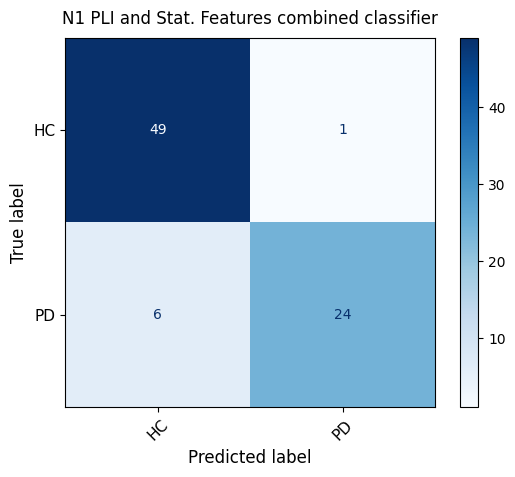

In [63]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels= ['HC' , 'PD'])
disp.plot( xticks_rotation=45, cmap=plt.cm.Blues)
plt.title('N1 PLI and Stat. Features combined classifier', pad = 10)

plt.xlabel('Predicted label', fontsize=12)  # Increase x-axis label size
plt.ylabel('True label', fontsize=12)  # Increase y-axis label size

# Increase tick labels size
plt.xticks(fontsize=11)  # Increase x-axis tick label size
plt.yticks(fontsize=11)  # Increase y-axis tick label size
plt.savefig('CM_best_clf.png', dpi = 200, bbox_inches="tight")